# Task 1

Points: 20

You will be working with RGBNet: a network that accepts pixel position as input and outputs a triplet with R, G, B channels of that pixels.
RGBNet is trained on a fixed image. Your tasks are:

1. (14 points) Fill gaps in the code, which creates embeddings in 2 ways:
    - Learned embedding of size 64 (7 points)
    - Positional embedding of size 64 (7 points)


Please note that your code should train within 1 minute and report training loss below 15 for each case.
2. (6 points) Visualize output of the network for each encoding. Does it resemble the input image?

In [1]:
import math
import urllib
from typing import Literal

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

IMG_URL = "https://i.natgeofe.com/k/8fa25ea4-6409-47fb-b3cc-4af8e0dc9616/red-eyed-tree-frog-on-leaves-3-2.jpg"

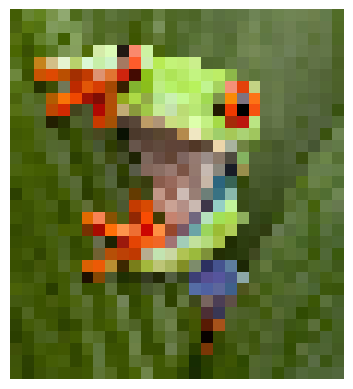

In [2]:
url_response = urllib.request.urlopen(IMG_URL)
img = cv2.imdecode(np.array(bytearray(url_response.read()), dtype=np.uint8), -1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = cv2.resize(img, (0,0), fx=0.01, fy=0.01) 
im_w, im_h = img.shape[0], img.shape[1]

plt.imshow(img)
plt.axis('off')
plt.show()

In [3]:
class NaiveEncoding(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.linear = nn.Linear(2, 64)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x.float())


class LearnedEncoding(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.x_embedding = nn.Embedding(im_w, 32)
        self.y_embedding = nn.Embedding(im_h, 32)       

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.cat((self.x_embedding(x[:, 0]), self.y_embedding(x[:, 1])), dim=-1)


class PositionalEncoding(nn.Module):    
  def __init__(self) -> None:
    super().__init__()  
    self.d_model = 64
    self.div_term = torch.exp(torch.arange(0, self.d_model // 2, 2).float()*(-torch.log(torch.Tensor([10.0])) / self.d_model // 2)).T.unsqueeze(0) 

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    pe_x = torch.zeros(x.size(0), self.d_model // 2)
    pe_x[:, 0::2] = torch.sin(x[:, 0].unsqueeze(1) * self.div_term)        
    pe_x[:, 1::2] = torch.cos(x[:, 0].unsqueeze(1) * self.div_term) 

    pe_y = torch.zeros(x.size(0), self.d_model // 2)
    pe_y[:, 0::2] = torch.sin(x[:, 1].unsqueeze(1) * self.div_term)        
    pe_y[:, 1::2] = torch.cos(x[:, 1].unsqueeze(1) * self.div_term)   

    return torch.cat([pe_x, pe_y], dim=1)  


# Define the network
class RGBNet(nn.Module):
    def __init__(self, encoding_type: Literal["naive", "learned", "positional"]) -> None:
        super().__init__()
        if encoding_type == "naive":
            self.encoding = NaiveEncoding()
        elif encoding_type == "learned":
            self.encoding = LearnedEncoding() 
        elif encoding_type == "positional":
            self.encoding = PositionalEncoding()
        else:
            raise ValueError("Wrong encoding type!")
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 3)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoding(x)
        x = F.softplus(self.fc1(x))
        x = F.softplus(self.fc2(x))
        x = self.fc3(x)
        return x


In [4]:
def train(used_embedding: Literal["naive", "learned", "positional"]) -> torch.nn.Module:
    # Instantiate the model and set it to the GPU (if available)
    model = RGBNet(encoding_type=used_embedding)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Define the loss function and optimizer
    criterion = nn.MSELoss(reduction="mean")
    optimizer = optim.AdamW(model.parameters(), lr=0.01)

    # Define the number of epochs and batch size
    num_epochs = 300
    batch_size = 32

    X, y = torch.cartesian_prod(torch.tensor(range(im_w)), torch.tensor(range(im_h))).to(device), torch.flatten(torch.tensor(img, dtype=torch.float32), start_dim=0, end_dim=1).to(device)

    model = model.train()

    # Train the model
    for epoch in range(num_epochs):
        total_loss = 0
        perm = torch.randperm(X.size(0))
        X, y = X[perm,:], y[perm, :]
        for i in range(0, X.shape[0], batch_size):
            # Get the current batch
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/X.size(0)}')
    return model

In [5]:
def visualize_model_output(model: RGBNet) -> None:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X = torch.cartesian_prod(torch.tensor(range(im_w)), torch.tensor(range(im_h))).to(device)
    model.eval()
    y_pred = model(X)

    y_pred = y_pred.view(im_w,im_h,3).long().detach().cpu().numpy()

    plt.imshow(y_pred)
    plt.axis('off')
    plt.show()


Epoch [1/300], Loss: 142.93318661456834
Epoch [2/300], Loss: 99.95835489721343
Epoch [3/300], Loss: 81.27373817549324
Epoch [4/300], Loss: 69.41179899576073
Epoch [5/300], Loss: 74.96248292703233
Epoch [6/300], Loss: 65.99191206830987
Epoch [7/300], Loss: 63.60057426487795
Epoch [8/300], Loss: 57.113132951446396
Epoch [9/300], Loss: 63.738692780244186
Epoch [10/300], Loss: 54.33149958316082
Epoch [11/300], Loss: 55.5446283015238
Epoch [12/300], Loss: 49.937124893961965
Epoch [13/300], Loss: 55.77938772456437
Epoch [14/300], Loss: 54.834808701194376
Epoch [15/300], Loss: 53.71642113610896
Epoch [16/300], Loss: 49.626993838543164
Epoch [17/300], Loss: 50.36072290657852
Epoch [18/300], Loss: 55.30360982165359
Epoch [19/300], Loss: 54.78060125535534
Epoch [20/300], Loss: 55.1770513859762
Epoch [21/300], Loss: 50.515020695699526
Epoch [22/300], Loss: 46.71161335184827
Epoch [23/300], Loss: 45.50724395189417
Epoch [24/300], Loss: 44.17769272975658
Epoch [25/300], Loss: 51.498519405241936
Epo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [300/300], Loss: 26.13787615683771


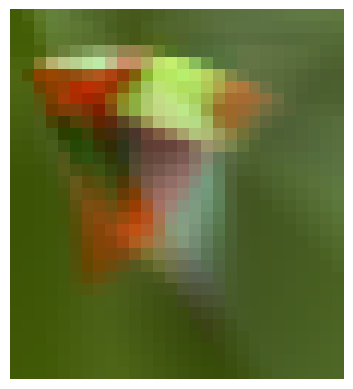

In [6]:
# IMPORTANT: 
# training code works only for 
# used_embedding = "naive"
# training and visualization code should work in both
# used_embedding = "learned"
# used_embedding = "positonal"
used_embedding = "naive"

torch.manual_seed(0)

model = train(used_embedding=used_embedding)
visualize_model_output(model)

Epoch [1/300], Loss: 128.57513624621976
Epoch [2/300], Loss: 56.93106567804715
Epoch [3/300], Loss: 51.762643137285785
Epoch [4/300], Loss: 51.36426491451703
Epoch [5/300], Loss: 49.62429957236013
Epoch [6/300], Loss: 45.679303375806676
Epoch [7/300], Loss: 44.7821051250405
Epoch [8/300], Loss: 45.73059349235851
Epoch [9/300], Loss: 46.17950425389725
Epoch [10/300], Loss: 39.474357552242715
Epoch [11/300], Loss: 38.90324176841068
Epoch [12/300], Loss: 35.17904736918788
Epoch [13/300], Loss: 32.46293390511368
Epoch [14/300], Loss: 33.04381937475248
Epoch [15/300], Loss: 32.725799982448876
Epoch [16/300], Loss: 31.21590138800133
Epoch [17/300], Loss: 29.46442423877628
Epoch [18/300], Loss: 26.982118562619256
Epoch [19/300], Loss: 26.445810098252537
Epoch [20/300], Loss: 26.890959884713872
Epoch [21/300], Loss: 25.139160085933
Epoch [22/300], Loss: 25.593888313539566
Epoch [23/300], Loss: 25.96682609171362
Epoch [24/300], Loss: 23.9325925413914
Epoch [25/300], Loss: 22.695484319590204
Epo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [298/300], Loss: 0.37870219171321884
Epoch [299/300], Loss: 0.2984850912050168
Epoch [300/300], Loss: 0.38709867165385303


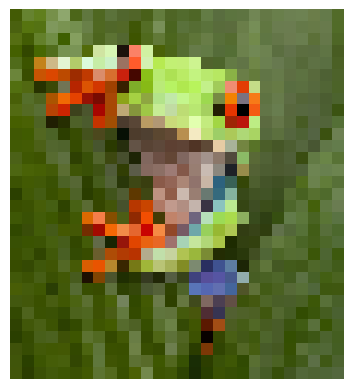

In [7]:
# IMPORTANT: 
# training code works only for 
# used_embedding = "naive"
# training and visualization code should work in both
# used_embedding = "learned"
# used_embedding = "positonal"
used_embedding = "learned"

torch.manual_seed(0)

model = train(used_embedding=used_embedding)
visualize_model_output(model)

Epoch [1/300], Loss: 118.95607043850806
Epoch [2/300], Loss: 64.65174577422955
Epoch [3/300], Loss: 58.76308096608808
Epoch [4/300], Loss: 60.52880437472998
Epoch [5/300], Loss: 58.10756482946159
Epoch [6/300], Loss: 58.624851490495395
Epoch [7/300], Loss: 55.00174108408563


/var/folders/zj/t76t6h4x71jcw3vjd48wt79m0000gn/T/ipykernel_13478/2671893781.py:24: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3281.)
  self.div_term = torch.exp(torch.arange(0, self.d_model // 2, 2).float()*(-torch.log(torch.Tensor([10.0])) / self.d_model // 2)).T.unsqueeze(0)


Epoch [8/300], Loss: 55.1867425452729
Epoch [9/300], Loss: 55.700071835847496
Epoch [10/300], Loss: 57.832040320893036
Epoch [11/300], Loss: 55.06233215332031
Epoch [12/300], Loss: 56.32163758871193
Epoch [13/300], Loss: 55.678759385913196
Epoch [14/300], Loss: 55.53399644139725
Epoch [15/300], Loss: 57.343226911834854
Epoch [16/300], Loss: 58.80640316449003
Epoch [17/300], Loss: 60.24464803247408
Epoch [18/300], Loss: 56.1438965687554
Epoch [19/300], Loss: 54.783463086950064
Epoch [20/300], Loss: 54.83139931111841
Epoch [21/300], Loss: 54.94806393390427
Epoch [22/300], Loss: 53.546568593671246
Epoch [23/300], Loss: 53.92962667579475
Epoch [24/300], Loss: 53.02059261480235
Epoch [25/300], Loss: 51.929666633430166
Epoch [26/300], Loss: 50.32144734606765
Epoch [27/300], Loss: 51.36791781236499
Epoch [28/300], Loss: 53.43727083689606
Epoch [29/300], Loss: 50.41474838960006
Epoch [30/300], Loss: 49.92771581131193
Epoch [31/300], Loss: 56.72337931971396
Epoch [32/300], Loss: 56.788506521057

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


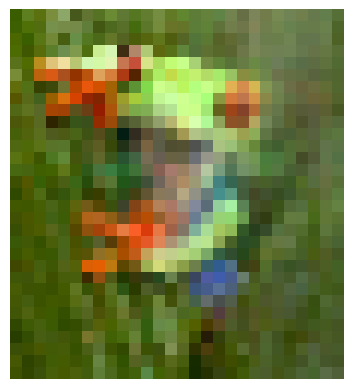

In [8]:
# IMPORTANT: 
# training code works only for 
# used_embedding = "naive"
# training and visualization code should work in both
# used_embedding = "learned"
# used_embedding = "positonal"
used_embedding = "positional"

torch.manual_seed(0)

model = train(used_embedding=used_embedding)
visualize_model_output(model)